In [1]:
import pandas as pd
import numpy as np
import random
from statsmodels.tsa.stattools import pacf
from matplotlib.pyplot import figure
from statsmodels.tsa.arima.model import ARIMA
# !pip install scikit-learn==0.24
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_lattice as tfl
import matplotlib.ticker as ticker

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
df = pd.read_csv("CACases.csv", index_col = False)
df.reset_index(drop=True, inplace=True)
df.head()

,date,Los Angeles,San Diego,San Francisco,Santa Barbara,Fresno,Sacramento,Ventura,Riverside
0,2020-02-01,13.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
1,2020-02-02,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2020-02-03,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2020-02-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-02-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# counties we are interested in
counties = ["Los Angeles", "San Diego", "San Francisco", "Santa Barbara",\
            "Fresno", "Sacramento", "Ventura", "Riverside"]

In [5]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# for each county
df1 = df.copy()  # deep copy
df1 = df1.iloc[6:]
for county in counties:
    # holder
    temp = []
    # take average, starting from 7th day
    for i in range(6,len(df)):
        # remove day of week effect
        ave = np.mean(df[county].iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
        temp.append(ave)
    df1[county] = temp
df1.set_index("date", inplace=True)

# Data Smoothing
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [6]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# for each county
df1 = df.copy()  # deep copy
df1 = df1.iloc[6:]
for county in counties:
    # holder
    temp = []
    # take average, starting from 7th day
    for i in range(6,len(df)):
        # remove day of week effect
        ave = np.mean(df[county].iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
        temp.append(ave)
    df1[county] = temp
df1.set_index("date", inplace=True)

In [7]:
# input: original dataset, county we want
# output: all data, sorted by date, of that county
def extract(dataset, county):
    # select data only from the input county
    temp = dataset.to_dict()[county]
    temp = pd.Series(temp)
    # reset index
    # temp.reset_index(drop=True, inplace=True)
    return temp

In [8]:
la = extract(df1, "Los Angeles")
la_raw = extract(df, "Los Angeles")
la_raw

0        13.0
1         4.0
2         4.0
3         1.0
4         0.0
        ...  
943    1320.0
944    1088.0
945     357.0
946      44.0
947       0.0
Length: 948, dtype: float64

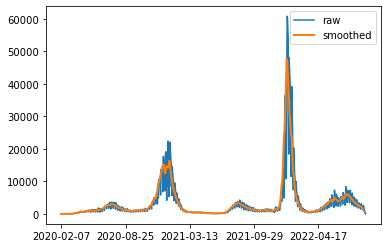

In [9]:
la_raw.plot(label = 'raw')
la.plot(linewidth = 2, label = "smoothed")
plt.legend()
fig_name = "LA_data.png"
plt.savefig(fig_name, dpi=600)

In [10]:
max(la)

47665.0

# Data Preprocessing
## Differencing
- Differencing of time series in discrete time
- transformation of series to a new time series wehre values are the difference between consecutive values of previous series
- help stablizing the mean of time series by removing trend

In [11]:
# create a differenced series, output as Series
# interval: order of differencing, default = 1
def difference(dataset, interval=1):
    diff = []
    for i in range(interval, len(dataset)):
        # no need to difference
        if (interval == 0):
            value = dataset[i]
        else:
            value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
# invert differenced value
# input: single original, single prediction, interval(default as 1)
def invert_difference(history, yhat, interval=1):
    if (interval == 0):
        return yhat
    else:
        return yhat + history

## Scaling
- Scale the data to [-1,1]

In [12]:
# scale train and test data to [-1, 1]
# input: train(np array, train_size*1), test(np array, test_size*1)
def scale(train, test):
    # find scalers
    aveTrain = np.mean(train)
    maxTrain = max(train)
    minTrain = min(train)
    scaler = [aveTrain, maxTrain, minTrain]
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = (train - aveTrain)/(maxTrain-minTrain)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = (test - aveTrain)/(maxTrain-minTrain)
    return scaler, train_scaled, test_scaled
# inverse scaling for a forecasted value
# input: scaler, single prediction yhat
def invert_scale(scaler, yhat):
    inverted = yhat*(scaler[1]-scaler[2]) + scaler[0]
    return inverted[0][0]  # output: a number

## Reshaping

In [13]:
# convert to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg  # output: a data frame
# prepare data for AR
def prepare_AR(series, diff, train_size, test_size, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # differencing
    diff_series = difference(raw_values, diff)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # split into train & test
    train_diff, test_diff = diff_values[:(train_size-diff)], diff_values[(train_size-diff):]
    # rescaling
    scaler, train_scaled, test_scaled = scale(train_diff, test_diff)
    # adjust data type for test_scaled
    # test_scaled = [row[0][0] for row in test_scaled]
    # convert to supervised
    train = [row[0][0] for row in train_scaled]
    test = series_to_supervised(test_scaled, n_lag, n_seq).values
    return scaler, train, test  # scaler: list, train: list, test: np array
# prepare data for neural networks
def prepare_nn(series, diff, train_size, test_size, n_lag, n_seq):
    # extract raw values
    raw_values = series.values
    raw_values = raw_values.reshape(len(raw_values), 1)
    # differencing
    diff_series = difference(raw_values, diff)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    # split into train & test
    train_diff, test_diff = diff_values[:(train_size-diff)], diff_values[(train_size-diff):]
    # rescaling
    scaler, train_scaled, test_scaled = scale(train_diff, test_diff)
    # adjust data type for train_scaled, test_scaled
    train_scaled = [row[0][0] for row in train_scaled]
    test_scaled = [row[0][0] for row in test_scaled]
    # convert to supervised
    train = series_to_supervised(train_scaled, n_lag, n_seq).values
    test = series_to_supervised(test_scaled, n_lag, n_seq).values
    return scaler, train, test  # scaler: list of np array, train: np array, test: np array

# Model Training

In [14]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # design network
    model = keras.Sequential()
    model.add(layers.LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(layers.Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [15]:
class alpha_layer(keras.layers.Layer):
    def __init__(self, input_dim=1, units=1):
        super(alpha_layer, self).__init__()
        # check with initializer.get_config()
        initializer = tf.keras.initializers.RandomUniform(minval = 0, maxval = 1)
        self.alpha = self.add_weight(shape=(input_dim, units), initializer=initializer, 
                                     constraint=lambda x: tf.clip_by_value(x, 0, 1), trainable=True)

    def call(self, input1, input2):
        return tf.matmul(input1, self.alpha) + tf.matmul(input2, (1-self.alpha))
# fit the hybrid model
def fit_comb(train, n_lag, n_seq, n_batch, n_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    Z = X.reshape(X.shape[0], 1, X.shape[1])
    # AR layer
    input1 = tf.keras.layers.Input(shape=(X.shape[1],))
    AR = tfl.layers.Linear(num_input_dims=X.shape[1], units=n_seq)(input1)
    
    # lstm layer
    input2 = tf.keras.layers.Input(shape=(Z.shape[1],Z.shape[2]))
    lstm = layers.LSTM(n_seq)(input2)
    # fully connected lstm
    lstm_connected = tf.keras.layers.Dense(n_seq)(lstm)
    
    # alpha layer
    layer = alpha_layer()
    #added = layer(AR, lstm)
    added = layer(AR, lstm_connected)
    model = tf.keras.models.Model(inputs=[input1,input2], outputs=added)
    # compile before training or testing
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    for i in range(n_epoch):
        model.fit([X, Z], y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Make Forecasts

In [16]:
# evaluate the model
def make_AR(model, raw_value, test, test_size, n_lag, n_seq, diff):
    forecasts = []
    prev = raw_value[-(test_size+diff):(len(raw_value)-diff)]  # Y_(t-diff)  # (train_size+n_lag-1):-1
    for i in range(test_size):
        X = test[i, 0:n_lag]  # X_test, will not use y_test
        # make forecast
        forecast = model.params[0]  # initlialize with coefficient
        for j in range(n_lag):
            forecast += model.params[j+1] * X[j]  # forecast = a0 + a_i * X_i for i = 1,...,7
        # invert scaling
        forecast = invert_scale(scaler, forecast)
        # invert differencing
        forecast = invert_difference(prev[i], forecast, diff)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [17]:
# make one forecast with an LSTM
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]][0]
# evaluate the model
def make_lstm(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff):
    forecasts = []
    prev = raw_value[-(test_size+diff):(len(raw_value)-diff)]  # Y_(t-diff)
    for i in range(len(test)):
        X = test[i, 0:n_lag]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # invert scaling
        forecast = invert_scale(scaler, forecast)
        # invert differencing
        forecast = invert_difference(prev[i], forecast)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [18]:
# make one forecast with a hybird model
def forecast_comb(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    Z = X.reshape(1, 1, len(X))
    X = X.reshape(1, len(X))
    # make forecast
    forecast = model.predict([X,Z], batch_size=n_batch)
    return [x for x in forecast[0, :]][0]
    return [x for x in forecast[0, :]][0]
# evaluate the model
def make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff):
    forecasts = []
    prev = raw_value[-(test_size+diff):(len(raw_value)-diff)]  # Y_(t-diff)
    for i in range(len(test)):
        X = test[i, 0:n_lag]
        # make forecast
        forecast = forecast_comb(model, X, n_batch)
        # invert scaling
        forecast = invert_scale(scaler, forecast)
        # invert differencing
        forecast = invert_difference(prev[i], forecast)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

## Evaluation with RMSE, MAE, MAPE

In [19]:
# evaluate RMSE for each step in forcasting
def evaluate_forecasts(truth, forecasts):
    rmse = np.sqrt(mean_squared_error(truth, forecasts))
    mae = mean_absolute_error(truth, forecasts)
    truth = np.array(truth)
    forecasts = np.array(forecasts)
    mape = mean_absolute_percentage_error(truth, forecasts)*100
    return rmse, mae, mape

# Perform on Interesting Trials

In [20]:
# given historical observations (t, t-1, t-2, … t-n+1) forecast t+1(future 1 day)
n_lag = 7  # number of lag, use 7 past days
n_seq = 1  # predict 1 future days
diff = 1 # order of difference
train_size = 63  # train set size
test_size = 18 # test set size

n_step = 7 

n_batch = 1
nb_epoch = 100
n_neurons = 1

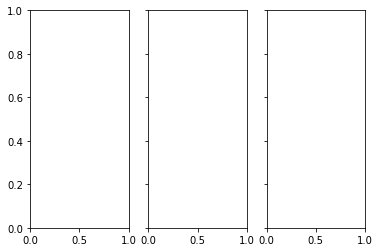

In [21]:
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')

# Case 1
## Curved Training Data and Down Trend Testing: San Diego 2020-12-03 to 2021-02-28

In [22]:
county = "San Diego"
s = extract(df1, county)
raw_value = s[300:300+(train_size+test_size+n_lag)]
raw_value

2020-12-03    1857.857143
2020-12-04    1887.142857
2020-12-05    1928.571429
2020-12-06    1942.571429
2020-12-07    2031.428571
                 ...     
2021-02-24     355.285714
2021-02-25     343.571429
2021-02-26     334.857143
2021-02-27     325.857143
2021-02-28     318.428571
Length: 88, dtype: float64

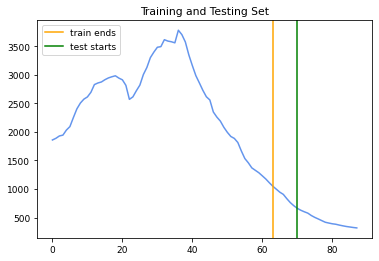

In [23]:
plt.rcParams.update({'font.size': 9})
fig.set_size_inches(18, 6, forward=True)
plt.plot(raw_value.values, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train ends')
plt.axvline(x = train_size+n_lag, color = 'green', label = 'test starts')
plt.title("Training and Testing Set")
plt.legend()
plt.savefig("SD_raw_2020-12-03_2021-02-28.png", dpi=600)

MAPE for AR: 2.5229930799201514
MAPE for LSTM: 3.1245642314237037
MAPE for Hybrid: 2.267171125814828


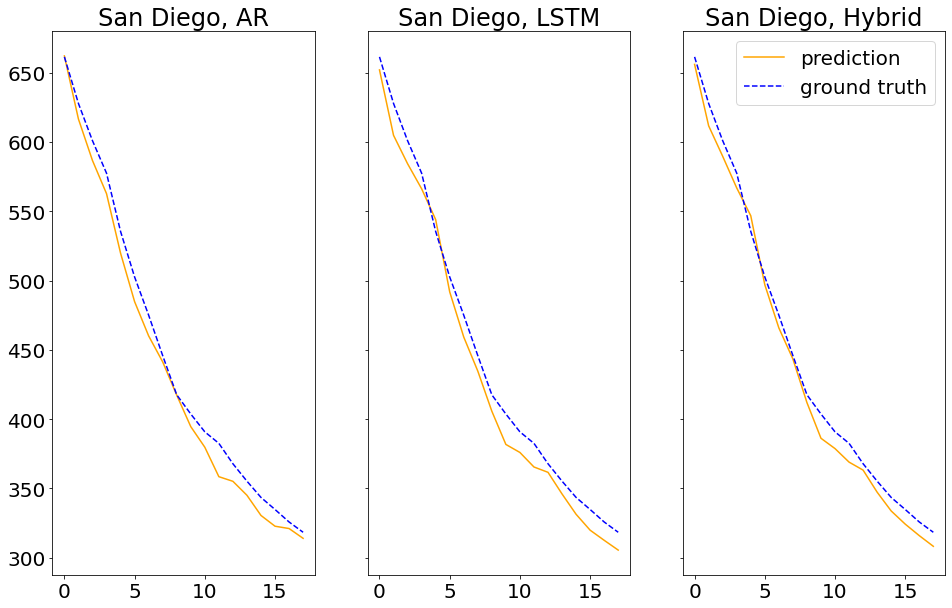

In [24]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(16, 10, forward=True)
# cut a data trial from original dataset
# prepare data
truth = raw_value[-test_size:].to_list()
# for AR
scaler, train, test = prepare_AR(raw_value, diff, train_size, test_size, n_lag, n_seq)
# fit model
model_AR = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
model_AR = model_AR.fit()
# make forecasts
forecasts = make_AR(model_AR, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
#plt.xticks(np.arange(0, 18, 1))
axs[0].plot(forecasts, color = 'orange', label = "prediction")
axs[0].plot(truth, 'b--', label = "ground truth")
axs[0].set_title("{}, AR".format(county))
print("MAPE for AR: {}".format(mape))

# for lstm
scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)
model_lstm = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_lstm(model_lstm, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[1].plot(forecasts, color = 'orange', label = "prediction")
axs[1].plot(truth, 'b--', label = "ground truth")
axs[1].set_title("{}, LSTM".format(county))
print("MAPE for LSTM: {}".format(mape))
    
# for hybrid
model = 0
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[2].plot(forecasts, color = 'orange', label = "prediction")
axs[2].plot(truth, 'b--', label = "ground truth")
axs[2].set_title("{}, Hybrid".format(county))
print("MAPE for Hybrid: {}".format(mape))
    
plt.legend()
fig_name = county + "_2020-12-03_2021-02-28.png"
plt.savefig(fig_name, dpi=600)

# Case 2
## Up Trend Training and Down Trend Testing: San Francisco 2020-02-17 to 2020-05-14

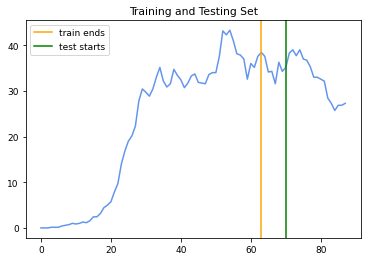

In [25]:
county = "San Francisco"
s = extract(df1, county)
raw_value = s[10:10+(train_size+test_size+n_lag)]
plt.rcParams.update({'font.size': 9})
fig.set_size_inches(18, 6, forward=True)
plt.plot(raw_value.values, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train ends')
plt.axvline(x = train_size+n_lag, color = 'green', label = 'test starts')
plt.title("Training and Testing Set")
plt.legend()
plt.savefig("SF_raw_2020-02-17_2020-05-14.png", dpi=600)

MAPE for AR: 6.173786765926804
MAPE for LSTM: 4.547535312748926
MAPE for Hybrid: 4.7458816466556915


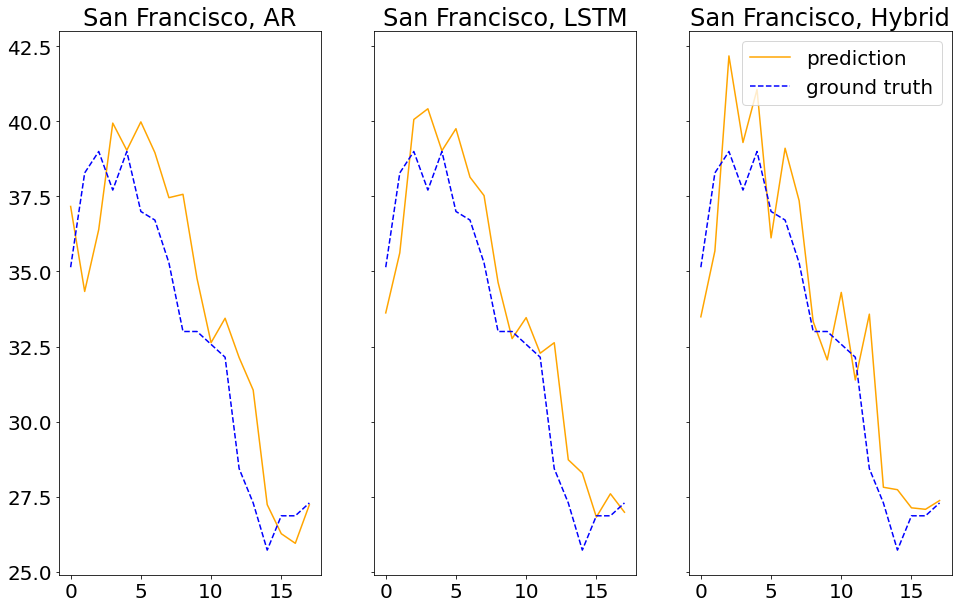

In [26]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(16, 10, forward=True)
# cut a data trial from original dataset
# prepare data
truth = raw_value[-test_size:].to_list()
# for AR
scaler, train, test = prepare_AR(raw_value, diff, train_size, test_size, n_lag, n_seq)
# fit model
model_AR = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
model_AR = model_AR.fit()
# make forecasts
forecasts = make_AR(model_AR, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
#plt.xticks(np.arange(0, 18, 1))
axs[0].plot(forecasts, color = 'orange', label = "prediction")
axs[0].plot(truth, 'b--', label = "ground truth")
axs[0].set_title("{}, AR".format(county))
print("MAPE for AR: {}".format(mape))

# for lstm
scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)
model_lstm = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_lstm(model_lstm, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[1].plot(forecasts, color = 'orange', label = "prediction")
axs[1].plot(truth, 'b--', label = "ground truth")
axs[1].set_title("{}, LSTM".format(county))
print("MAPE for LSTM: {}".format(mape))
    
# for hybrid
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[2].plot(forecasts, color = 'orange', label = "prediction")
axs[2].plot(truth, 'b--', label = "ground truth")
axs[2].set_title("{}, Hybrid".format(county))
print("MAPE for Hybrid: {}".format(mape))
    
plt.legend()
fig_name = county + "_2020-02-17_2020-05-14.png"
plt.savefig(fig_name, dpi=600)

# Case 3
## Up Trend Training and Up Trend Testing: Los Angeles 2020-09-24 to 2020-12-20

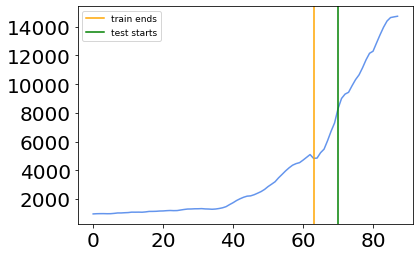

In [27]:
county = "Los Angeles"
s = extract(df1, county)
raw_value = s[230:230+(train_size+test_size+n_lag)]
plt.plot(raw_value.values, color = 'cornflowerblue')
plt.rcParams.update({'font.size': 9})
fig.set_size_inches(18, 6, forward=True)
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train ends')
plt.axvline(x = train_size+n_lag, color = 'green', label = 'test starts')
# plt.title("Training and Testing Set")
plt.legend()
plt.savefig("LA_raw_2020-09-24_2020-12-20.png", dpi = 600)

MAPE for AR: 2.368485838440594
MAPE for LSTM: 2.0356082405493354
MAPE for Hybrid: 1.6526050822833218


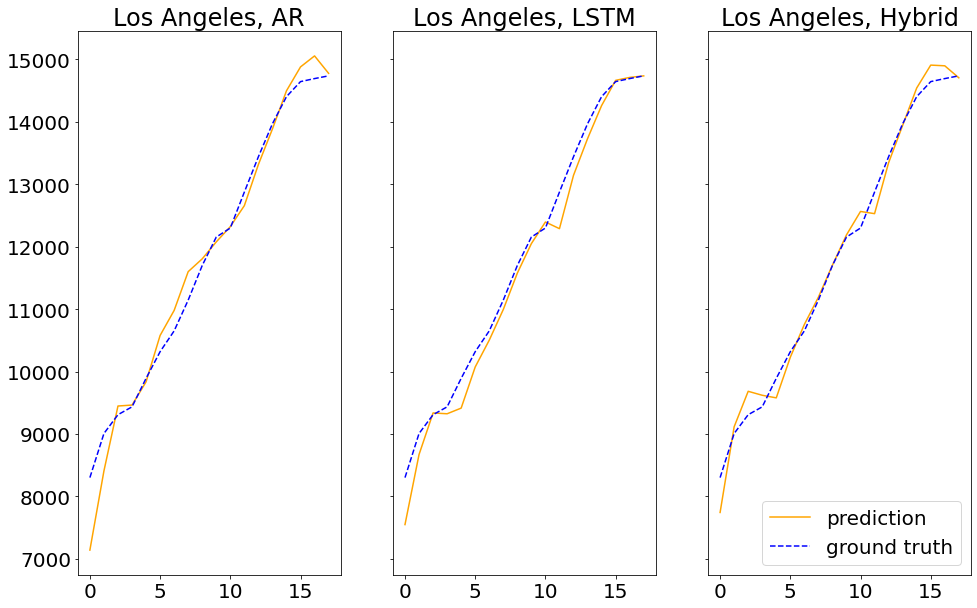

In [28]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(16, 10, forward=True)
# plt.setp(axs, xticks=np.arange(0, 19, 6))
# plt.xticks(np.arange(0, 19, 6))
# cut a data trial from original dataset
# prepare data
truth = raw_value[-test_size:].to_list()
# for AR
scaler, train, test = prepare_AR(raw_value, diff, train_size, test_size, n_lag, n_seq)
# fit model
model_AR = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
model_AR = model_AR.fit()
# make forecasts
forecasts = make_AR(model_AR, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[0].plot(forecasts, color = 'orange', label = "prediction")
axs[0].plot(truth, 'b--', label = "ground truth")
axs[0].set_title("{}, AR".format(county))
print("MAPE for AR: {}".format(mape))

# for lstm
scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)
model_lstm = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_lstm(model_lstm, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[1].plot(forecasts, color = 'orange', label = "prediction")
axs[1].plot(truth, 'b--', label = "ground truth")
axs[1].set_title("{}, LSTM".format(county))
print("MAPE for LSTM: {}".format(mape))
    
# for hybrid
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[2].plot(forecasts, color = 'orange', label = "prediction")
axs[2].plot(truth, 'b--', label = "ground truth")
axs[2].set_title("{}, Hybrid".format(county))
print("MAPE for Hybrid: {}".format(mape))
    
plt.legend()
fig_name = county + "_2020-09-24_2020-12-20" + ".png"
plt.savefig(fig_name, dpi=600)

# Case 4
## Down Trend Training and Down Trend Testing: San Francisco 2022-06-10 to 2022-09-05

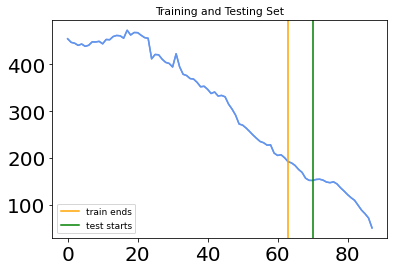

In [29]:
county = "San Francisco"
s = extract(df1, county)
raw_value = s[-(train_size+test_size+n_lag):]  # last trial
plt.plot(raw_value.values, color = 'cornflowerblue')
plt.rcParams.update({'font.size': 9})
fig.set_size_inches(18, 6, forward=True)
plt.plot(raw_value.values, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train ends')
plt.axvline(x = train_size+n_lag, color = 'green', label = 'test starts')
plt.title("Training and Testing Set")
plt.legend()
plt.savefig("SF_raw_2022-06-10_2022-09-05.png", dpi=600)

MAPE for AR: 5.251342370628336
MAPE for LSTM: 3.8056431213421007
MAPE for Hybrid: 4.082569987154925


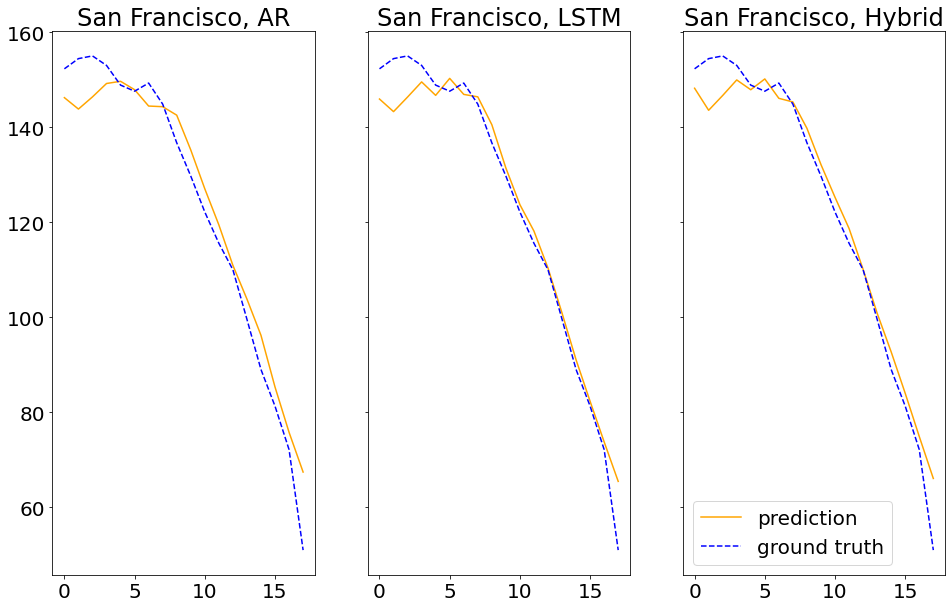

In [30]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(16, 10, forward=True)
# cut a data trial from original dataset
# prepare data
truth = raw_value[-test_size:].to_list()
# for AR
scaler, train, test = prepare_AR(raw_value, diff, train_size, test_size, n_lag, n_seq)
# fit model
model_AR = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
model_AR = model_AR.fit()
# make forecasts
forecasts = make_AR(model_AR, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
#plt.xticks(np.arange(0, 18, 1))
axs[0].plot(forecasts, color = 'orange', label = "prediction")
axs[0].plot(truth, 'b--', label = "ground truth")
axs[0].set_title("{}, AR".format(county))
print("MAPE for AR: {}".format(mape))

# for lstm
scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)
model_lstm = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_lstm(model_lstm, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[1].plot(forecasts, color = 'orange', label = "prediction")
axs[1].plot(truth, 'b--', label = "ground truth")
axs[1].set_title("{}, LSTM".format(county))
print("MAPE for LSTM: {}".format(mape))
    
# for hybrid
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[2].plot(forecasts, color = 'orange', label = "prediction")
axs[2].plot(truth, 'b--', label = "ground truth")
axs[2].set_title("{}, Hybrid".format(county))
print("MAPE for Hybrid: {}".format(mape))
    
plt.legend()
fig_name = county + "_2022-06-10_2022-09-05.png"
plt.savefig(fig_name, dpi=600)

# Case 5
## Down Trend Training and Up Trend Testing: Santa Barbara 2022-01-17 to 2022-04-14

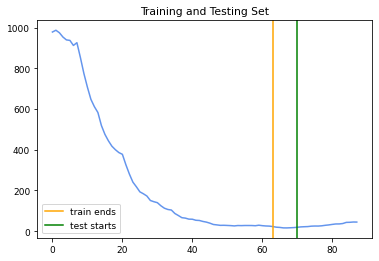

In [31]:
county = "Santa Barbara"
s = extract(df1, county)
raw_value = s[710:710+(train_size+test_size+n_lag)]
plt.rcParams.update({'font.size': 9})
fig.set_size_inches(18, 6, forward=True)
plt.plot(raw_value.values, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train ends')
plt.axvline(x = train_size+n_lag, color = 'green', label = 'test starts')
plt.title("Training and Testing Set")
plt.legend()
plt.savefig("SB_raw_2022-01-17_2022-04-14.png", dpi=600)

MAPE for AR: 9.060824307481845
MAPE for LSTM: 10.22040893062663
MAPE for Hybrid: 6.814839957466195


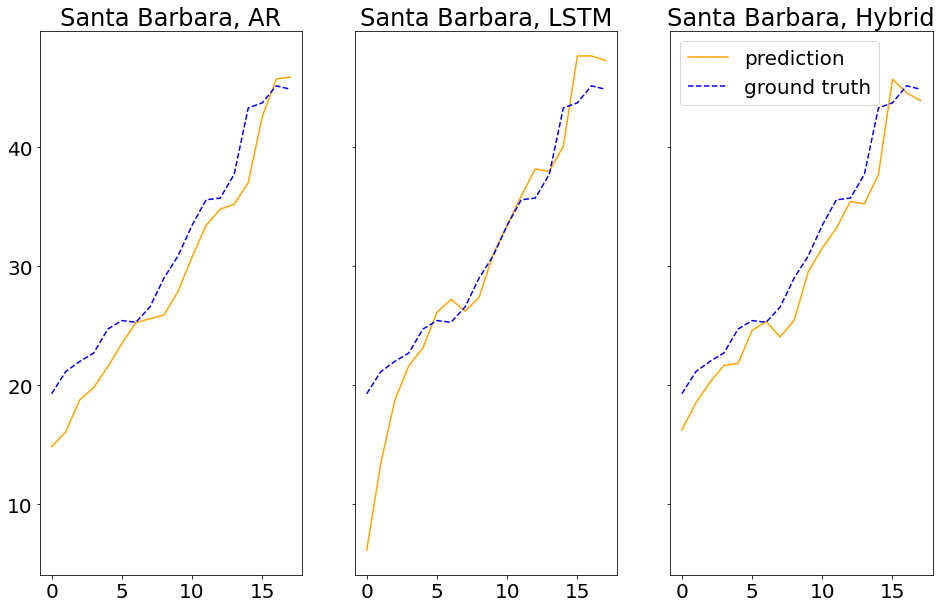

In [32]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(16, 10, forward=True)
# cut a data trial from original dataset
# prepare data
truth = raw_value[-test_size:].to_list()
# for AR
scaler, train, test = prepare_AR(raw_value, diff, train_size, test_size, n_lag, n_seq)
# fit model
model_AR = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
model_AR = model_AR.fit()
# make forecasts
forecasts = make_AR(model_AR, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
#plt.xticks(np.arange(0, 18, 1))
axs[0].plot(forecasts, color = 'orange', label = "prediction")
axs[0].plot(truth, 'b--', label = "ground truth")
axs[0].set_title("{}, AR".format(county))
print("MAPE for AR: {}".format(mape))

# for lstm
scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)
model_lstm = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_lstm(model_lstm, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[1].plot(forecasts, color = 'orange', label = "prediction")
axs[1].plot(truth, 'b--', label = "ground truth")
axs[1].set_title("{}, LSTM".format(county))
print("MAPE for LSTM: {}".format(mape))
    
# for hybrid
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[2].plot(forecasts, color = 'orange', label = "prediction")
axs[2].plot(truth, 'b--', label = "ground truth")
axs[2].set_title("{}, Hybrid".format(county))
print("MAPE for Hybrid: {}".format(mape))
    
plt.legend()
fig_name = county + "_2022-01-17_2022-04-14" + ".png"
plt.savefig(fig_name, dpi=600)

## Riverside 2022-02-16 to 2022-05-14

In [33]:
county = "Riverside"
s = extract(df1, county)
raw_value = s[740:740+(train_size+test_size+n_lag)]
raw_value

2022-02-16    553.428571
2022-02-17    504.285714
2022-02-18    454.428571
2022-02-19    420.285714
2022-02-20    394.714286
                 ...    
2022-05-10    358.285714
2022-05-11    366.428571
2022-05-12    382.857143
2022-05-13    399.571429
2022-05-14    422.428571
Length: 88, dtype: float64

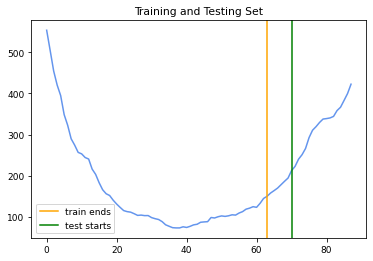

In [34]:
plt.rcParams.update({'font.size': 9})
fig.set_size_inches(18, 6, forward=True)
plt.plot(raw_value.values, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train ends')
plt.axvline(x = train_size+n_lag, color = 'green', label = 'test starts')
plt.title("Training and Testing Set")
plt.legend()
plt.savefig("Riv_raw_2022-02-16_2022-05-14.png", dpi=600)

MAPE for AR: 4.355928272364528
MAPE for LSTM: 2.818895562434281
MAPE for Hybrid: 1.9397291508009653


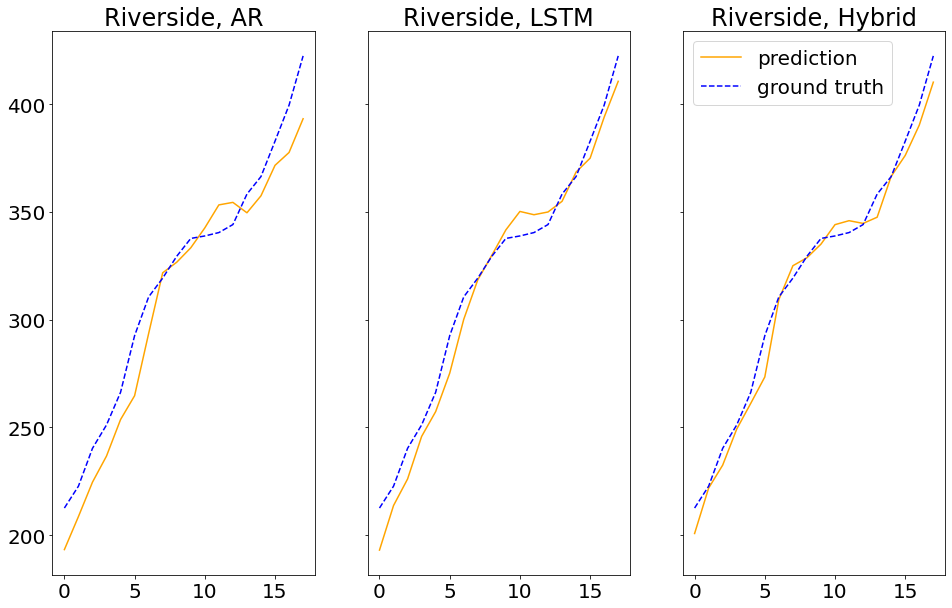

In [35]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(16, 10, forward=True)
# cut a data trial from original dataset
# prepare data
truth = raw_value[-test_size:].to_list()
# for AR
scaler, train, test = prepare_AR(raw_value, diff, train_size, test_size, n_lag, n_seq)
# fit model
model_AR = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
model_AR = model_AR.fit()
# make forecasts
forecasts = make_AR(model_AR, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
#plt.xticks(np.arange(0, 18, 1))
axs[0].plot(forecasts, color = 'orange', label = "prediction")
axs[0].plot(truth, 'b--', label = "ground truth")
axs[0].set_title("{}, AR".format(county))
print("MAPE for AR: {}".format(mape))

# for lstm
scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)
model_lstm = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_lstm(model_lstm, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[1].plot(forecasts, color = 'orange', label = "prediction")
axs[1].plot(truth, 'b--', label = "ground truth")
axs[1].set_title("{}, LSTM".format(county))
print("MAPE for LSTM: {}".format(mape))
    
# for hybrid
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[2].plot(forecasts, color = 'orange', label = "prediction")
axs[2].plot(truth,'b--', label = "ground truth")
axs[2].set_title("{}, Hybrid".format(county))
print("MAPE for Hybrid: {}".format(mape))
    
plt.legend()
fig_name = county + "_2022-02-16_2022-05-14.png"
plt.savefig(fig_name, dpi=600)

# Case 6
## Jegged Testing: Fresno 2021-02-11 to 2021-05-09

In [36]:
county = "Fresno"
s = extract(df1, county)
raw_value = s[370:370+(train_size+test_size+n_lag)]
raw_value

2021-02-11    198.571429
2021-02-12    189.714286
2021-02-13    182.857143
2021-02-14    183.000000
2021-02-15    174.571429
                 ...    
2021-05-05     53.571429
2021-05-06     53.857143
2021-05-07     52.428571
2021-05-08     50.571429
2021-05-09     49.285714
Length: 88, dtype: float64

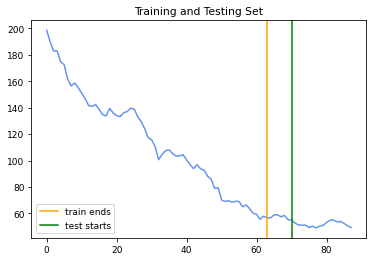

In [37]:
plt.rcParams.update({'font.size': 9})
fig.set_size_inches(18, 6, forward=True)
plt.plot(raw_value.values, color = 'cornflowerblue')
# visualize the split of test/train
plt.axvline(x = train_size, color = 'orange', label = 'train ends')
plt.axvline(x = train_size+n_lag, color = 'green', label = 'test starts')
plt.title("Training and Testing Set")
plt.legend()
plt.savefig("Fres_raw_2021-02-11_2021-05-09.png", dpi=600)

MAPE for AR: 3.674989167338274
MAPE for LSTM: 5.525083313661275
MAPE for Hybrid: 3.579837392865238


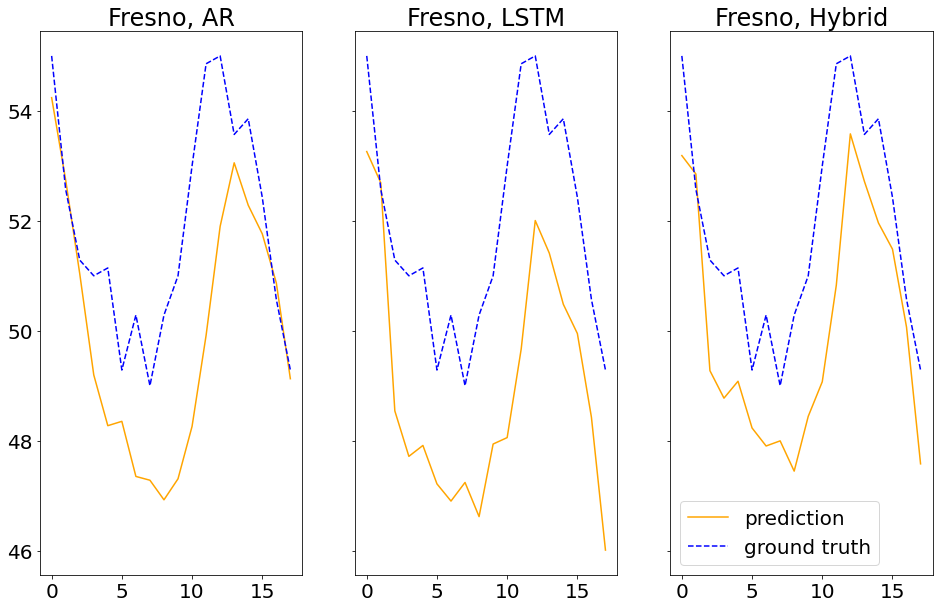

In [38]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(16, 10, forward=True)
# cut a data trial from original dataset
# prepare data
truth = raw_value[-test_size:].to_list()
# for AR
scaler, train, test = prepare_AR(raw_value, diff, train_size, test_size, n_lag, n_seq)
# fit model
model_AR = ARIMA(train, order = (n_lag,0,0), trend = 'c')  # AR, I, MA
model_AR = model_AR.fit()
# make forecasts
forecasts = make_AR(model_AR, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
#plt.xticks(np.arange(0, 18, 1))
axs[0].plot(forecasts, color = 'orange', label = "prediction")
axs[0].plot(truth, 'b--', label = "ground truth")
axs[0].set_title("{}, AR".format(county))
print("MAPE for AR: {}".format(mape))

# for lstm
scaler, train, test = prepare_nn(raw_value, diff, train_size, test_size, n_lag, n_seq)
model_lstm = fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_lstm(model_lstm, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[1].plot(forecasts, color = 'orange', label = "prediction")
axs[1].plot(truth, 'b--', label = "ground truth")
axs[1].set_title("{}, LSTM".format(county))
print("MAPE for LSTM: {}".format(mape))
    
# for hybrid
model = 0
model = fit_comb(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons)
forecasts = make_comb(model, n_batch, raw_value, test, test_size, n_lag, n_seq, diff)
rmse, mae, mape = evaluate_forecasts(raw_value[-test_size:], forecasts)
axs[2].plot(forecasts, color = 'orange', label = "prediction")
axs[2].plot(truth, 'b--', label = "ground truth")
axs[2].set_title("{}, Hybrid".format(county))
print("MAPE for Hybrid: {}".format(mape))
    
plt.legend()
fig_name = county + "_2021-02-11_2021-05-09.png"
plt.savefig(fig_name, dpi=600)